In [1]:
import torch
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os, sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.dont_write_bytecode = True

In [2]:
class z_score:
    def __init__(self, x):
        self.mean = float(np.mean(x))
        self.std = float(np.std(x))
    def transform(self, data): 
        out = (np.array(data) - self.mean)/self.std
        return out
    def reform(self, data):
        out = data*self.std + self.mean
        return out
    
class MyDataSet(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        return x

class Student(nn.Module):
    def __init__(self, n_dim, n_hid, z_score):
        super(Student, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_dim, n_dim//2),
            nn.ReLU(),
            nn.Linear(n_dim//2, n_dim//4),
            nn.ReLU(),
            nn.Linear(n_dim//4, n_hid)
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_hid, n_dim//4),
            nn.ReLU(),
            nn.Linear(n_dim//4, n_dim//2),
            nn.ReLU(),
            nn.Linear(n_dim//2, n_dim)
        )
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.n_dim = n_dim
        self.z_score = z_score

    def forward(self, x):
        x = self.z_score.transform(x)
        x = [x[i-self.n_dim:i] for i in range(self.n_dim, len(x))]
        x = torch.tensor(x).to(torch.float32)
        x = self.quant(x)
        out = self.encoder(x)
        out = self.decoder(out)
        out = self.dequant(out)
        out = self.z_score.reform(out)
        return out[:, -1].tolist()
    
    def _train(self, x):
        # Quantization
        x = self.quant(x)

        # Z and reconstruction
        z = self.encoder(x)
        x_hat = self.decoder(z)

        # De-quantization
        x_hat = self.dequant(x_hat)
        z = self.dequant(z)

        return x_hat, z
    
    def anomaly(self, x):
        x = self.z_score.transform(x)
        data = [x[i-self.n_dim:i] for i in range(self.n_dim, len(x))]
        data = torch.tensor(data).to(torch.float32)
        data = self.quant(data)
        out = self.encoder(data)
        out = self.decoder(out)
        pred = self.dequant(out)
        recon = pred[:, -1]
        scores = (recon - torch.tensor(x[-recon.shape[0]:]).to(torch.float32))**2
        return scores.tolist()
    
def fit(data, teacher):
    # Train the teacher first
    teacher.train()
    teacher.fit(data)
    teacher.eval()

    # Setup training paras
    epochs = 0
    history = list()
    
    # Call the student
    _z_score = z_score(data)
    student = Student(teacher.n_dim, (teacher.n_hid2 * 2 + teacher.n_dim)//8, _z_score)
    student.train()
    data = _z_score.transform(data)
    data = torch.tensor([data[i-teacher.n_dim:i] for i in range(teacher.n_dim, len(data))]).to(torch.float32)
    dataloader = DataLoader(MyDataSet(data), batch_size = 1024, shuffle = True)
    optimizer = optim.AdamW(student.parameters(), lr = 1e-4, weight_decay = 1e-2)
    while True:
        try:
            epochs += 1
            resp_loss = .0
            feat_loss = .0
            for d in dataloader:
                x_t, _, f_t, _ = teacher._train(d.to(next(teacher.parameters()).device))
                x_s, f_s = student._train(d)
                r_loss = nn.MSELoss()(x_s, x_t.to(next(student.parameters()).device))
                f_loss = nn.MSELoss()(f_s, f_t.to(next(student.parameters()).device))
                loss = r_loss + f_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                resp_loss += r_loss.item()
                feat_loss += f_loss.item()
            history += [[resp_loss, feat_loss]]

            fig, ax = plt.subplots(1, 2, figsize = (12, 2))
            clear_output()
            temp_hist = np.array(history)
            ## 畫數值
            ax[0].plot(temp_hist[:, 0], color = "blue", marker = '.', label = "responsive loss")
            ax[1].plot(temp_hist[:, 1], color = "blue", marker = ".", label = "feature loss")

            ## 畫窗格
            ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
            ax[1].grid(linestyle = "--", color = "gray", alpha = .4)

            ## 畫標籤
            ax[0].legend()
            ax[1].legend()
            plt.show()
            if epochs == 100: break
        except KeyboardInterrupt:
            break
    return student


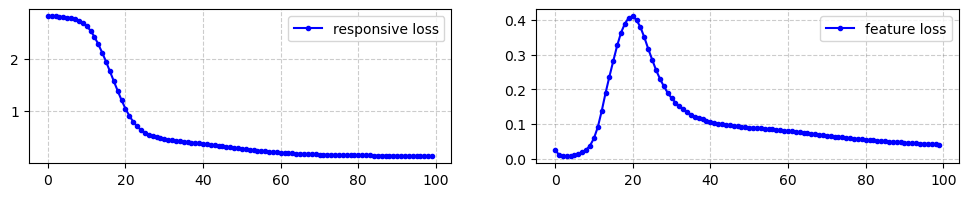

In [3]:
from model import FCVAE
path = "./artificialNoAnomaly/"
files = os.listdir(path)
cols = ["timestamp", "value"]
data = pd.read_csv(path + files[0])[cols[1]].tolist()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher = FCVAE(n_dim = 1024, n_hid1 = 512, n_hid2 = 256, n_seq = 128).to(device)
student = fit(data, teacher)

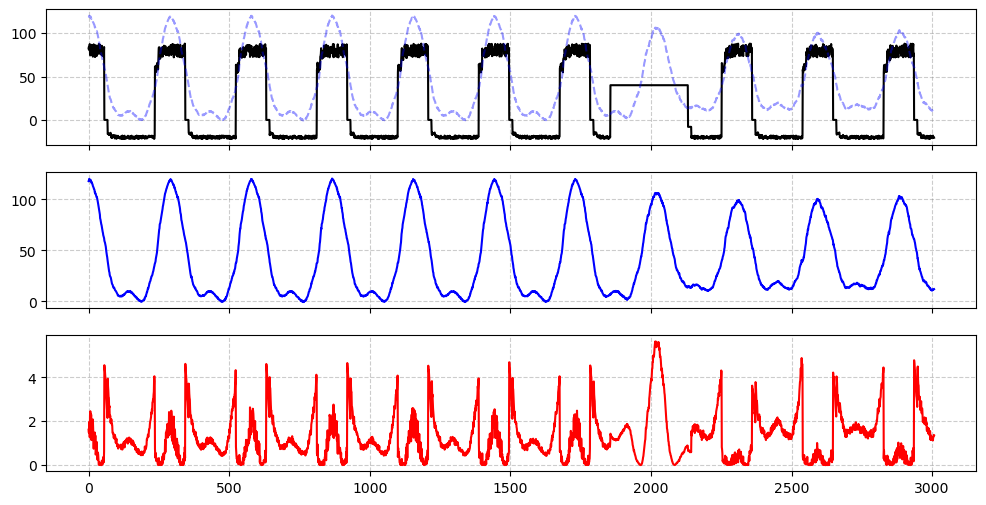

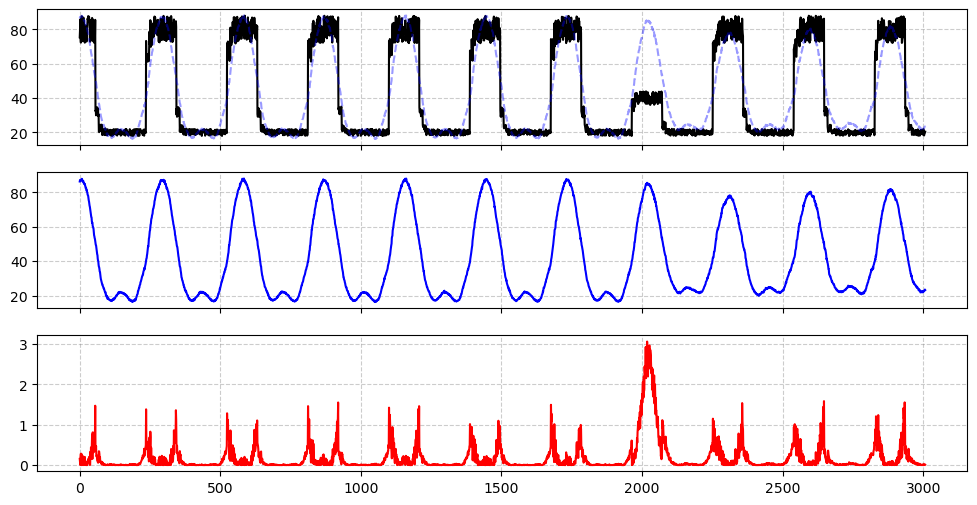

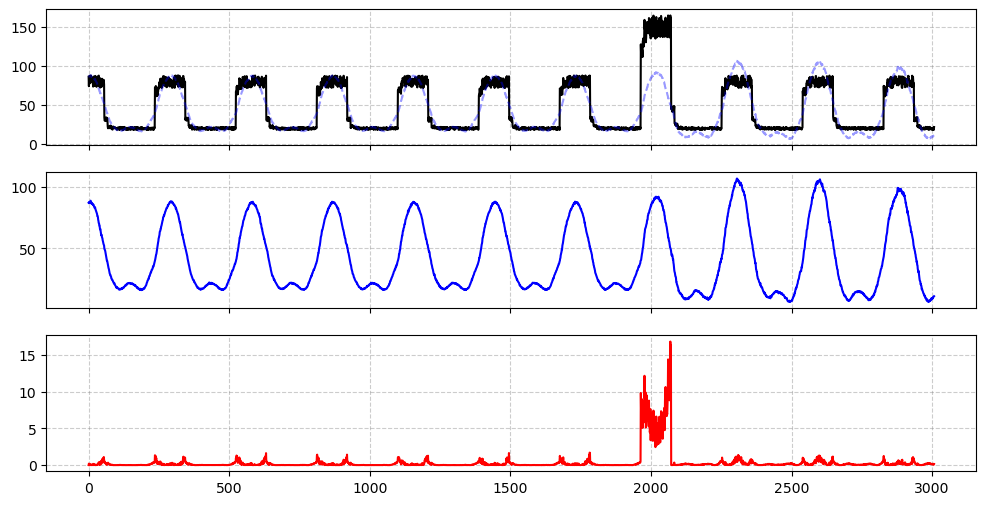

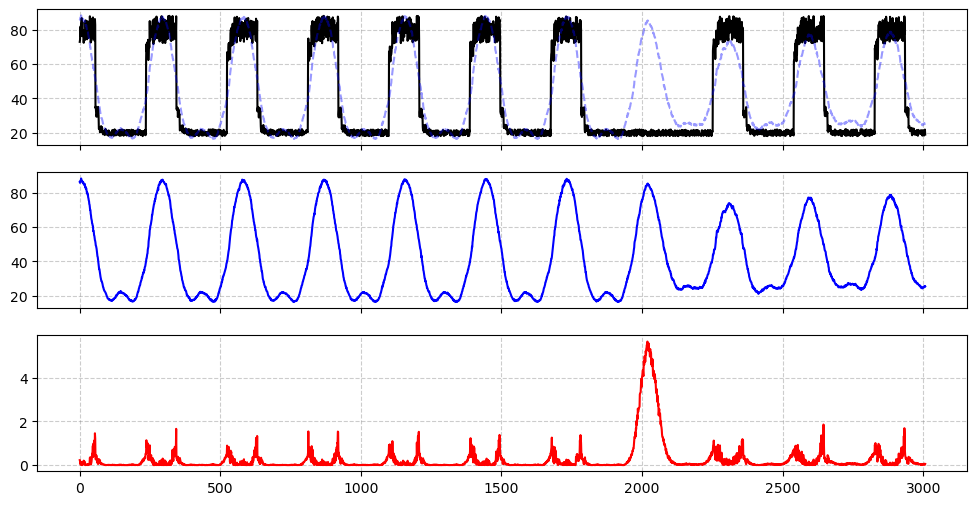

In [4]:
path = "./artificialWithAnomaly/"
files = os.listdir(path)
cols = ["timestamp", "value"]

for case in (0, 1, 2, 3):
    ts_data = pd.read_csv(path + files[case])[cols[1]].tolist()

    anomalies = student.anomaly(ts_data)
    recon = student(ts_data)

    fig, ax = plt.subplots(3, 1, figsize = (12, 6), sharex=True)
    ax[0].plot(ts_data[-len(recon):], color = "black")
    ax[0].plot(recon, color = "blue", linestyle = "--", alpha = .4)
    ax[1].plot(recon, color = "blue", linestyle = "-")
    ax[2].plot(anomalies, color = "red")
    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[2].grid(linestyle = "--", color = "gray", alpha = .4)
    plt.show()